>Stock Market Prediction Using Stacked LSTM

> Mukarram Ali 

> mirali.mukarram@gmail.com

> linkedin.com/in/mukarramali0/

> December 2020





In [1]:
#Mounting drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# importing libraries
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
import unicodedata


In [3]:
!pip install -q keras 

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

In [4]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Data 

In [5]:
stock_headlines = pd.read_csv('/content/drive/MyDrive/stock data/india-news-headlines.csv')

In [6]:
stock_price = pd.read_csv('/content/drive/MyDrive/stock data/APPL(1).csv')

In [7]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227281,452312000
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250200,817073600
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.260704,739396000
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.250200,412356000
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.253065,373699200


In [8]:
stock_headlines.head(3)

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit


Checking for null values with heatmap

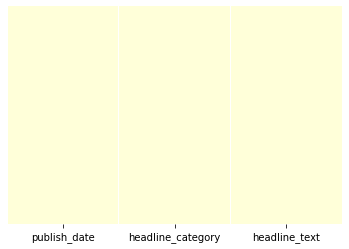

In [10]:
sns.heatmap(stock_headlines.isnull(),yticklabels=False,cmap="YlGnBu",cbar=False)

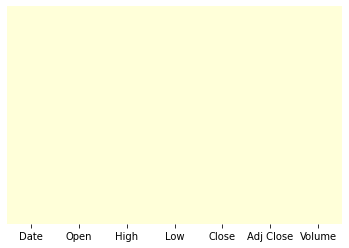

In [12]:
sns.heatmap(stock_price.isnull(),yticklabels=False,cmap="YlGnBu",cbar=False)

In [13]:
stock_price.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [14]:
#Droppinbg duplicates
stock_price = stock_price.drop_duplicates()
#Converting data type of date from object to datetime
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()


In [15]:
#Filtering the columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200
...,...,...,...,...,...
2020-11-27,116.589996,116.570000,117.489998,116.220001,46691300
2020-11-30,119.050003,116.970001,120.970001,116.809998,169410200
2020-12-01,122.720001,121.010002,123.470001,120.010002,128166800


In [16]:
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5013 entries, 2001-01-02 to 2020-12-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5013 non-null   float64
 1   Open    5013 non-null   float64
 2   High    5013 non-null   float64
 3   Low     5013 non-null   float64
 4   Volume  5013 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 235.0 KB


Stock headlines 

In [17]:
stock_headlines.columns

Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')

In [18]:
#Droppinbg duplicates
stock_headlines = stock_headlines.drop_duplicates()


In [19]:
#Converting data type of date from string to datetime
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()


In [20]:
# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

In [21]:
# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()
stock_headlines

,publish_date,headline_text
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-03,"Powerless north India gropes in the dark,Think..."
3,2001-01-04,The string that pulled Stephen Hawking to Indi...
4,2001-01-05,Light combat craft takes India into club class...
...,...,...
7075,2020-06-26,Containment zone residents slam high prices ch...
7076,2020-06-27,like me i wont let you have a toxic relationsh...
7077,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...
7078,2020-06-29,6 hot and stylish bikini looks of Katrina Kaif...


In [22]:
# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)
# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-01,win over cena satisfying but defeating underta...
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
...,...
2020-06-26,Containment zone residents slam high prices ch...
2020-06-27,like me i wont let you have a toxic relationsh...
2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...


Concatenating both the data sets  

In [23]:
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

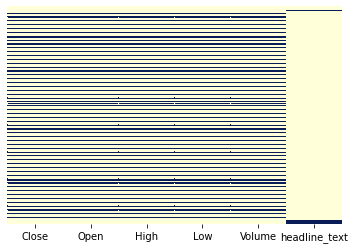

In [24]:
sns.heatmap(stock_data.isnull(),yticklabels=False,cmap="YlGnBu",cbar=False)

In [25]:
#dropping null values 
stock_data.dropna(axis=0, inplace=True)

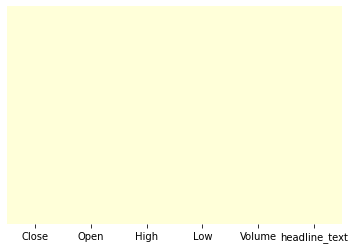

In [26]:
sns.heatmap(stock_data.isnull(),yticklabels=False,cmap="YlGnBu",cbar=False)

In [27]:
stock_data.head(5)

,Close,Open,High,Low,Volume,headline_text
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru..."


In [28]:
#Calculation of  Sentiment Scores
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...,,,,
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think...",,,,
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...,,,,
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...,,,,
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru...",,,,


In [29]:
# installation of Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [30]:
stock_data.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'headline_text', 'compound',
       'negative', 'neutral', 'positive'],
      dtype='object')

In [31]:
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [32]:
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])

In [33]:
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])

In [34]:
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

In [35]:
stock_data.head(5)

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...,0.9032,0.105,0.746,0.149
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026


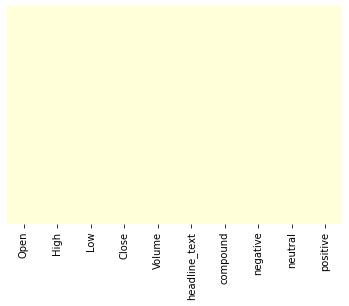

In [ ]:
#checking for null values
sns.heatmap(stock_data.isnull(),yticklabels=False,cmap="YlGnBu",cbar=False)

dropping headlines text unwanted now

In [36]:
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

In [39]:
stock_data.head(3)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0


In [42]:
#saving to disk 
stock_data.to_csv('stock_data.csv')

In [45]:
stock_data.shape

(4877, 9)

In [46]:
#null values
stock_data.isna().sum()

Close       0
compound    0
negative    0
neutral     0
positive    0
Open        0
High        0
Low         0
Volume      0
dtype: int64

In [47]:
#Statistical perspective of Stock data
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4877.000000,4.877000e+03
mean,17.237386,-0.870185,0.125720,0.788116,0.086175,17.228087,17.402949,17.056717,4.511259e+08
std,18.701168,0.453365,0.024431,0.033153,0.020881,18.670832,18.873534,18.499968,3.857601e+08
min,0.234286,-1.000000,0.000000,0.000000,0.000000,0.231964,0.235536,0.227143,2.019780e+07
25%,2.132857,-0.999800,0.112000,0.768000,0.075000,2.136429,2.165357,2.096071,1.774828e+08
50%,10.901428,-0.999000,0.127000,0.785000,0.086000,10.900000,11.000000,10.746428,3.374672e+08
75%,27.350000,-0.994100,0.141000,0.806000,0.096000,27.334999,27.605000,27.100000,6.051080e+08
max,91.632500,1.000000,0.444000,1.000000,0.608000,91.250000,93.095001,90.567497,3.372970e+09


Text(0, 0.5, 'Close Price ($)')

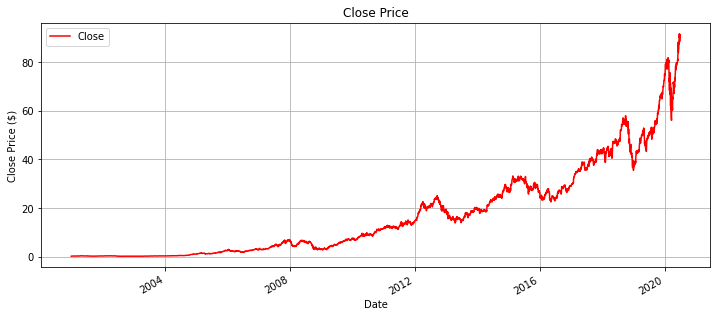

In [89]:
# plotting close price
Colse = stock_data['Close'].plot(legend=True,figsize=(12,5,), color="r")
Colse.grid(True)
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [49]:
#Calculation of rolling mean of 7 days 
stock_data.rolling(7).mean().head(25)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,0.293368,-0.179071,0.121714,0.810429,0.067571,0.293088,0.304687,0.281728,566364000.0
2001-01-11,0.301340,-0.041629,0.117857,0.810286,0.071571,0.296596,0.312978,0.286033,616567200.0
2001-01-23,0.311862,0.000843,0.111000,0.818429,0.070429,0.308873,0.323820,0.297832,625489600.0
2001-01-24,0.320631,-0.223257,0.113714,0.821286,0.064714,0.315210,0.329400,0.304847,622303200.0


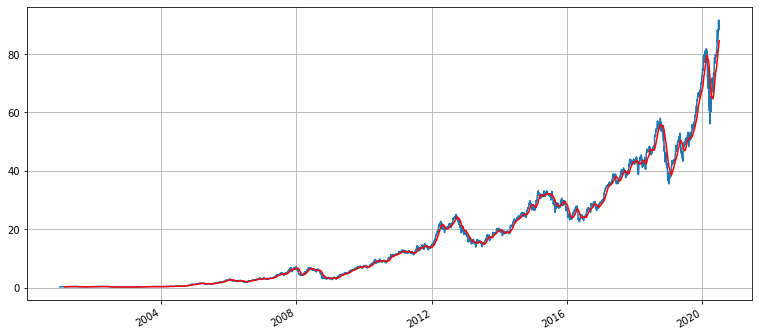

In [90]:
#Plotting the close price and  30-day rolling mean of close price
plt.figure(figsize=(13,6))
stock_data['Close'].plot()
closed_30RMean=stock_data.rolling(window=30).mean()['Close'].plot( color="r")
closed_30RMean.grid(True)



In [51]:
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.9032,0.105,0.746,0.149,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0
...,...,...,...,...,...,...,...,...,...
2020-06-24,90.014999,-0.9997,0.115,0.811,0.074,91.250000,92.197502,89.629997,192623200.0
2020-06-25,91.209999,-0.9999,0.126,0.820,0.054,90.175003,91.250000,89.392502,137522400.0
2020-06-26,88.407501,-0.9999,0.149,0.766,0.085,91.102501,91.330002,88.254997,205256800.0
2020-06-29,90.445000,-0.9997,0.119,0.804,0.078,88.312500,90.542503,87.820000,130646000.0


In [52]:

#calculation of data to use 
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3900
Number of records in Test Data: 977


In [53]:
#Data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume


In [54]:
close_price

2001-01-03     0.292411
2001-01-04     0.304688
2001-01-05     0.292411
2001-01-08     0.295759
2001-01-09     0.306920
                ...    
2020-06-24    90.014999
2020-06-25    91.209999
2020-06-26    88.407501
2020-06-29    90.445000
2020-06-30    91.199997
Name: Close, Length: 4876, dtype: float64

In [55]:

#next day close
close_price_shifted = close_price.shift(-1) 

#next day compound
compound_shifted = compound.shift(-1) 

# concatenating into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

In [56]:
data.head()

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2001-01-03,0.292411,0.304688,0.6322,0.6648,817073600.0,0.258929,0.297991,0.257813
2001-01-04,0.304688,0.292411,0.6648,0.9032,739396000.0,0.323940,0.330357,0.300223
2001-01-05,0.292411,0.295759,0.9032,-0.9638,412356000.0,0.302455,0.310268,0.286830
2001-01-08,0.295759,0.306920,-0.9638,-0.9559,373699200.0,0.302455,0.303292,0.284598
2001-01-09,0.306920,0.295759,-0.9559,-0.5719,588929600.0,0.300223,0.315011,0.295759


In [58]:
data = data.dropna() 

In [60]:
data.isna().sum()

close_price            0
close_price_shifted    0
compound               0
compound_shifted       0
volume                 0
open_price             0
high                   0
low                    0
dtype: int64

Setting the Target variable 

In [61]:
y = data['close_price_shifted']
y

2001-01-03     0.304688
2001-01-04     0.292411
2001-01-05     0.295759
2001-01-08     0.306920
2001-01-09     0.295759
                ...    
2020-06-23    90.014999
2020-06-24    91.209999
2020-06-25    88.407501
2020-06-26    90.445000
2020-06-29    91.199997
Name: close_price_shifted, Length: 4875, dtype: float64

Features  for prediction  

In [62]:
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2001-01-03,0.292411,0.6322,0.6648,817073600.0,0.258929,0.297991,0.257813
2001-01-04,0.304688,0.6648,0.9032,739396000.0,0.323940,0.330357,0.300223
2001-01-05,0.292411,0.9032,-0.9638,412356000.0,0.302455,0.310268,0.286830
2001-01-08,0.295759,-0.9638,-0.9559,373699200.0,0.302455,0.303292,0.284598
2001-01-09,0.306920,-0.9559,-0.5719,588929600.0,0.300223,0.315011,0.295759
...,...,...,...,...,...,...,...
2020-06-23,91.632500,-0.9999,-0.9997,212155600.0,91.000000,93.095001,90.567497
2020-06-24,90.014999,-0.9997,-0.9999,192623200.0,91.250000,92.197502,89.629997
2020-06-25,91.209999,-0.9999,-0.9999,137522400.0,90.175003,91.250000,89.392502
2020-06-26,88.407501,-0.9999,-0.9997,205256800.0,91.102501,91.330002,88.254997


Scaling the Target Variable

In [63]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)


Preparation of train and test dataset

In [64]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

Reshaping 

In [65]:
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))


Stock Data Modelling


In [66]:

#seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

#Model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [67]:
#Compilation of the  model
model.compile(loss='mse' , optimizer='adam')

In [68]:
#Fitting the model 
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
390/390 [==============================] - 6s 16ms/step - loss: 0.0317 - val_loss: 0.1177
Epoch 2/10
390/390 [==============================] - 5s 14ms/step - loss: 0.0085 - val_loss: 0.0037
Epoch 3/10
390/390 [==============================] - 5s 14ms/step - loss: 0.0025 - val_loss: 3.5439e-04
Epoch 4/10
390/390 [==============================] - 5s 13ms/step - loss: 0.0019 - val_loss: 4.4489e-04
Epoch 5/10
390/390 [==============================] - 5s 13ms/step - loss: 0.0017 - val_loss: 2.1954e-04
Epoch 6/10
390/390 [==============================] - 5s 14ms/step - loss: 0.0015 - val_loss: 9.5258e-04
Epoch 7/10
390/390 [==============================] - 5s 13ms/step - loss: 0.0013 - val_loss: 8.8318e-04
Epoch 8/10
390/390 [==============================] - 5s 14ms/step - loss: 0.0014 - val_loss: 2.8428e-04
Epoch 9/10
390/390 [==============================] - 5s 14ms/step - loss: 0.0013 - val_loss: 2.3248e-04
Epoch 10/10
390/390 [==============================] - 5s 14ms/

Predictions

In [69]:
predictions = model.predict(X_test) 
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[28.400915],
       [28.240316],
       [28.341825],
       [28.260744],
       [28.14785 ]], dtype=float32)

In [70]:
#Mean-squared-error of training data
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

#Mean-squared-error of  test data 
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

#Mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))


974/974 [==============================] - 3s 3ms/step - loss: 0.0025
Train Loss = 0.0007
Test Loss = 0.0025


In [71]:
#root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 51.6795


Plotting the Predictions with untrained data

In [72]:
# unscaling 
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

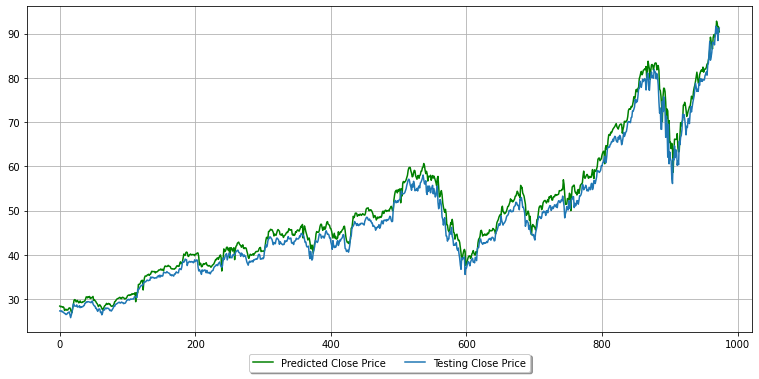

In [91]:
plt.figure(figsize=(13,6))
plt.plot(predictions, label="Predicted Close Price", color="g")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
